# Stock Price Forecaseting with Long-Short Term Memory (LSTM)

## 1. Introduction
Although stock prices are prone to fluctuations, stock prices tend to follow trends based on previous days prices and trends, assuming that there is no news that may significantly affect the price of a stock. This resulted in traders buying stocks based on long-term trends of its previous prices, as well as reading candlestick patterns to try to predict the movement of the stock price.

<br>

With this observation, we decided to experiement with using long short-term memory networks (LSTM) to predict stock price base on two components - its short term price and it's long term price. Stock prices is a perfect application for LSTM models as it is a time-series data. 

<br>
Let's start off by importing the libraries that we need


In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error



## 2a. Preprocessing

In [2]:
start_date = '2015-01-01'
end_date = '2019-12-31'

# Import dataset
df = pd.read_csv("datasets/aapl_stock_raw.csv", index_col=0)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.drop(columns=["adjclose", "volume", "ticker"], inplace=True)

# Remove entries outside daterange
df = df[start_date:end_date]

df['change'] = df['close'] - df['open']


fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])])

fig.show()
df

,open,high,low,close,change
date,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,-0.514999
2015-01-05,27.072500,27.162500,26.352501,26.562500,-0.510000
2015-01-06,26.635000,26.857500,26.157499,26.565001,-0.070000
2015-01-07,26.799999,27.049999,26.674999,26.937500,0.137501
2015-01-08,27.307501,28.037500,27.174999,27.972500,0.664999
...,...,...,...,...,...
2019-12-24,71.172501,71.222504,70.730003,71.067497,-0.105003
2019-12-26,71.205002,72.495003,71.175003,72.477501,1.272499
2019-12-27,72.779999,73.492500,72.029999,72.449997,-0.330002


In [3]:
# Drop all columns except for closing price and date (index)
close_df = df[['close']]
close_df

,close
date,
2015-01-02,27.332500
2015-01-05,26.562500
2015-01-06,26.565001
2015-01-07,26.937500
2015-01-08,27.972500
...,...
2019-12-24,71.067497
2019-12-26,72.477501
2019-12-27,72.449997


## 2b. Exploratory Data Analysis
Analyse dataset features

In [4]:
df.describe()

,open,high,low,close,change
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000
mean,38.599344,38.939050,38.268752,38.619141,0.019797
std,11.002370,11.103250,10.925538,11.029897,0.464672
min,22.500000,22.917500,22.367500,22.584999,-2.275002
25%,28.950001,29.130624,28.627500,28.876250,-0.209376
50%,37.593750,38.012501,37.293751,37.638750,0.030001
75%,46.500627,46.845624,46.167500,46.500626,0.261876
max,72.779999,73.492500,72.379997,73.412498,2.217499


## 2c. Prepare training set and normalise data
x_train is an array containing the data as well as the N future prices

In [65]:
# Prepare training set
train_df = close_df['2015-01-01':'2018-12-31']

# Normalise data
scaler = MinMaxScaler(feature_range=(0,1))      # Explore using StandardScaler instead of MinMaxScaler in the future
scaled_data = scaler.fit_transform(train_df['close'].values.reshape(-1,1))

# Number of days to base prediction on:
N_PRED_DAYS = 50

x_train, y_train = [], []

for d in range(N_PRED_DAYS, len(scaled_data)):
    # Add previous days values to x_train
    x_train.append(scaled_data[d - N_PRED_DAYS: d, 0])
    # Add current day's value to y_train
    y_train.append(scaled_data[d, 0])

# Convert into numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

x_train, y_train

(array([[[0.13398719],
         [0.11225571],
         [0.11232629],
         ...,
         [0.24066886],
         [0.23460098],
         [0.2441967 ]],
 
        [[0.11225571],
         [0.11232629],
         [0.12283922],
         ...,
         [0.23460098],
         [0.2441967 ],
         [0.25894307]],
 
        [[0.11232629],
         [0.12283922],
         [0.15204968],
         ...,
         [0.2441967 ],
         [0.25894307],
         [0.26903268]],
 
        ...,
 
        [[0.89621107],
         [0.93000767],
         [0.92323429],
         ...,
         [0.42609183],
         [0.39857476],
         [0.47153035]],
 
        [[0.93000767],
         [0.92323429],
         [0.8867565 ],
         ...,
         [0.39857476],
         [0.47153035],
         [0.46433354]],
 
        [[0.92323429],
         [0.8867565 ],
         [0.9099696 ],
         ...,
         [0.47153035],
         [0.46433354],
         [0.46489801]]]),
 array([0.25894307, 0.26903268, 0.26218867, 0.25089961,

# 3. Build LSTM Model


In [66]:
def LSTM_model():
    
    model = Sequential()
    
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=1))
    
    return model

# Training

In [67]:
model = LSTM_model()
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error')

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 50, 50)            10400     
                                                                 
 dropout_24 (Dropout)        (None, 50, 50)            0         
                                                                 
 lstm_25 (LSTM)              (None, 50, 50)            20200     
                                                                 
 dropout_25 (Dropout)        (None, 50, 50)            0         
                                                                 
 lstm_26 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_26 (Dropout)        (None, 50)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                

In [68]:
# Define callbacks, saving only the best model
checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', 
                               verbose = 2, 
                               save_best_only = True,
                               monitor='loss'
                               )

hist = model.fit(x_train, 
          y_train, 
          epochs=35, 
          batch_size = 32,
          callbacks = [checkpointer])



Epoch 1/35
29/30 [============================>.] - ETA: 0s - loss: 0.0239
Epoch 1: loss improved from inf to 0.02335, saving model to weights_best.hdf5
30/30 [==============================] - 5s 36ms/step - loss: 0.0233
Epoch 2/35
29/30 [============================>.] - ETA: 0s - loss: 0.0060
Epoch 2: loss improved from 0.02335 to 0.00593, saving model to weights_best.hdf5
30/30 [==============================] - 1s 36ms/step - loss: 0.0059
Epoch 3/35
29/30 [============================>.] - ETA: 0s - loss: 0.0053
Epoch 3: loss improved from 0.00593 to 0.00531, saving model to weights_best.hdf5
30/30 [==============================] - 1s 37ms/step - loss: 0.0053
Epoch 4/35
29/30 [============================>.] - ETA: 0s - loss: 0.0046
Epoch 4: loss improved from 0.00531 to 0.00464, saving model to weights_best.hdf5
30/30 [==============================] - 1s 37ms/step - loss: 0.0046
Epoch 5/35
29/30 [============================>.] - ETA: 0s - loss: 0.0038
Epoch 5: loss improved fr

## 5. Predictions

First we prepare actual_prices, which will contain the actual price of the stock in our testing timeframe, which is 01-01-2019 to 31-12-2019. 

Next, we prepare the model inputs. Our model inputs will include the previous 50 days from the start of the test dataset, which is 18-10-2018. We perform a reshape and then a scaler transform to scale the values of our inputs.

In [90]:
# Prepare test dataset (2019)
test_df = close_df['2019-01-01':'2019-12-31']
actual_prices = test_df['close'].values

model_inputs = close_df[len(train_df) - N_PRED_DAYS:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

model_inputs

,close
date,
2019-01-02,39.480000
2019-01-03,35.547501
2019-01-04,37.064999
2019-01-07,36.982498
2019-01-08,37.687500
...,...
2019-12-24,71.067497
2019-12-26,72.477501
2019-12-27,72.449997


To predict the prices, we first append the model input as well as its corresponding past 50 days into x_test, for each day. 

x_test is then converted into a numpy array and reshaped into a 3D array with the appropriate dimensions for our LSTM model. 

Using our LSTM model, we predict the prices on a sliding window basis. The price of a stock on any particular day is fed in the inputs of our past 50 days prices only. This gives us better accuracy as compared to using a one-shot prediction method. 

In [122]:
x_test = []

for d in range(N_PRED_DAYS, len(model_inputs)):
    x_test.append(model_inputs[d - N_PRED_DAYS: d, 0])

# Convert to numpy array and reshape to 3D array with appropriate dimensions for LSTM model
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Predict the prices 
predicted_prices = model.predict(x_test)
# Perform an inverse transform to obtain actual values
predicted_prices = scaler.inverse_transform(predicted_prices)


8/8 [==============================] - 0s 13ms/step


The predicted prices is then plotted with the actual prices. We can see that the shape of the predicted prices follows roughly to the actual price. However, it is worth noting that the prices were predicted using a sliding window method, which allows for better prediction of the actual prices. In reality, we might want a one-shot prediction that predicts further into the future. 

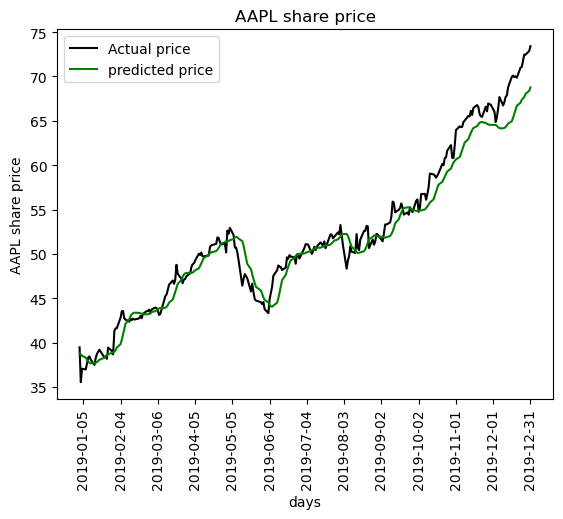

In [97]:
# Plot predicted prices
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.xticks(rotation = 90)
x_dates = test_df.index
plt.plot(x_dates, actual_prices, color='black', label=f"Actual price")
plt.plot(x_dates, predicted_prices, color= 'green', label=f"predicted price")
plt.title("AAPL share price")
plt.xlabel("days")
plt.ylabel("AAPL share price")
plt.legend()
plt.show()

## 6. Evaluation
From our results, we can see that LSTM is able to predict the price with a deviation of 2.60% given N = 50 days worth of data. This represents that for any price that our model predicts, it should vary 2.60% from the actual value. This deviation is too large for short term traders but may be useful for mid-term traders.

In [98]:
# Calculate the error as a percentage
diff = []
for day in range(len(actual_prices)):
    diff.append(abs(predicted_prices[day][0] - actual_prices[day]) / actual_prices[day])

print(sum(diff) / len(diff) * 100, "%")

2.5993439919177868 %


Evaluating our model using the built in evaluation metrics, we get a Mean-Square-Error (MSE) of 2712.124

In [100]:
score = model.evaluate(predicted_prices, actual_prices, verbose=0) 
print("MSE:", score)

MSE: 2712.124267578125


# 7. Experimenting with Different Values of N

We repeat what we have done, but with different values of N_PRED_DAYS, namely N = 7 (1 week) and N = 100. To make it easier, we wrap the steps above into a single function.

In [124]:
def lstm_predict(n):
    x_train, y_train = [], []

    for d in range(n, len(scaled_data)):
        # Add previous days values to x_train
        x_train.append(scaled_data[d - n: d, 0])
        # Add current day's value to y_train
        y_train.append(scaled_data[d, 0])    

    # Convert into numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Def LSTM model
    # We change the number of units the model has such that it scales with n. Larger n will result in the model 'remembering' more of the dataset, but risks overfitting
    def LSTM_model():
        model = Sequential()
        
        model.add(LSTM(units = n, return_sequences = True, input_shape = (x_train.shape[1],1)))
        model.add(Dropout(0.2))

        model.add(LSTM(units = n, return_sequences = True))
        model.add(Dropout(0.2))

        model.add(LSTM(units = n))
        model.add(Dropout(0.2))
        
        model.add(Dense(units=1))
        
        return model
    
    # Initialize LSTM model 
    model = LSTM_model()
    model.summary()
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Define callbacks, saving only the best model
    checkpointer = ModelCheckpoint(filepath = 'n' + str(n) + '_weights_best.hdf5', 
                                verbose = 2, 
                                save_best_only = True,
                                monitor='loss'
                                )

    # Train model 
    hist = model.fit(x_train, 
            y_train, 
            epochs=35, 
            batch_size = 32,
            callbacks = [checkpointer])
    

    # Prepare model inputs
    model_inputs = close_df[len(train_df) - n:].values
    model_inputs = model_inputs.reshape(-1,1)
    model_inputs = scaler.transform(model_inputs)


    x_test = []

    for d in range(n, len(model_inputs)):
        x_test.append(model_inputs[d - n: d, 0])

    # Convert to numpy array and reshape to 3D array with appropriate dimensions for LSTM model
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # Predict the prices 
    predicted_prices = model.predict(x_test)
    predicted_prices = scaler.inverse_transform(predicted_prices)

    # Plot predicted prices 
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
    plt.xticks(rotation = 90)
    x_dates = test_df.index
    plt.plot(x_dates, actual_prices, color='black', label=f"Actual price")
    plt.plot(x_dates, predicted_prices, color= 'green', label=f"predicted price")
    plt.title("AAPL share price")
    plt.xlabel("days")
    plt.ylabel("AAPL share price")
    plt.legend()
    plt.show()


    # Calculate the error as a percentage
    diff = []
    for day in range(len(actual_prices)):
        diff.append(abs(predicted_prices[day][0] - actual_prices[day]) / actual_prices[day])

    print(sum(diff) / len(diff) * 100, "%")

    # Evaluate model using previous evaluation metrics
    score = model.evaluate(predicted_prices, actual_prices, verbose=0) 
    print("MSE:", score)


## 7a. N_PRED_DAYS = 7

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_54 (LSTM)              (None, 7, 7)              252       
                                                                 
 dropout_54 (Dropout)        (None, 7, 7)              0         
                                                                 
 lstm_55 (LSTM)              (None, 7, 7)              420       
                                                                 
 dropout_55 (Dropout)        (None, 7, 7)              0         
                                                                 
 lstm_56 (LSTM)              (None, 7)                 420       
                                                                 
 dropout_56 (Dropout)        (None, 7)                 0         
                                                                 
 dense_18 (Dense)            (None, 1)               

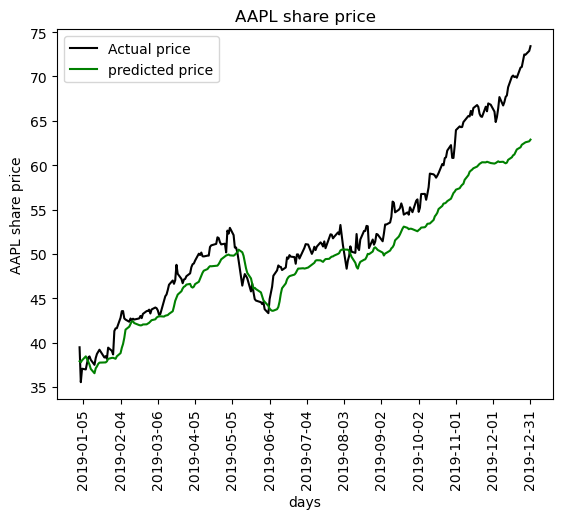

5.264214591289141 %
MSE: 2749.630615234375


In [120]:
lstm_predict(7)

## 7b. With N_PRED_DAYS = 100

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 100, 100)          40800     
                                                                 
 dropout_60 (Dropout)        (None, 100, 100)          0         
                                                                 
 lstm_61 (LSTM)              (None, 100, 100)          80400     
                                                                 
 dropout_61 (Dropout)        (None, 100, 100)          0         
                                                                 
 lstm_62 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_62 (Dropout)        (None, 100)               0         
                                                                 
 dense_20 (Dense)            (None, 1)               

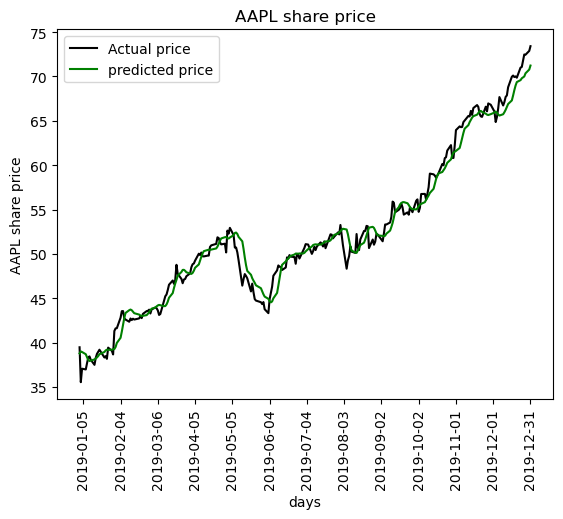

1.8668878186605504 %
MSE: 2620.49365234375


In [125]:
lstm_predict(100)

## 7c. Observations
By increasing the number of days we base our prediction on, the accuracy improved resulting in a better fit curve and the uncertainty decreasing from 5.26% to 1.87%. The MSE decreased from 2750 to 2620.

However, the increased accuracy comes at a cost of longer training time due to the significant increase in the number of parameters, and the risk of overfitting the model